# Tweet Turing Test: Detecting Disinformation on Twitter  

|          | Group #2 - Disinformation Detectors                     |
|---------:|---------------------------------------------------------|
| Members  | John Johnson, Katy Matulay, Justin Minnion, Jared Rubin |
| Notebook | `07b_ML_Model_tweet_text_features.ipynb`                        |
| Purpose  | ML models                |

This notebook contains the ML Models run against the tweet text features only (28 cols), using max possible tweets to train/test (3Million).

# 1 - Setup

In [1]:
# imports from Python standard library

# imports requiring installation
#   connection to Google Cloud Storage
from google.cloud import storage            # pip install google-cloud-storage
from google.oauth2 import service_account   # pip install google-auth

#  data science packages
import numpy as np                          # pip install numpy
import pandas as pd                         # pip install pandas

In [2]:
!pip install demoji
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import demoji
import seaborn as sns
import nltk
from datetime import date
import regex as re
import pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 1.3 MB/s eta 0:00:00


In [3]:
#pipeline
#!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
#models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
#evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_auc_score  ##plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_classif

%matplotlib inline

In [4]:
#Colab Specific workflow - remove for github
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# pandas options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

## Local or Cloud?

Decide here whether to run notebook with local data or GCP bucket data
 - if the working directory of this notebook has a "../data/" folder with data loaded (e.g. working on local computer or have data files loaded to a cloud VM) then use the "local files" option and comment out the "gcp bucket files" option
 - if this notebook is being run from a GCP VM (preferrably in the `us-central1` location) then use the "gcp bucket files" option and comment out the "local files" option

In [ ]:
# option: local files
local_or_cloud: str = "local"   # comment/uncomment this line or next

# option: gcp bucket files
#local_or_cloud: str = "cloud"   # comment/uncomment this line or previous

# don't comment/uncomment for remainder of cell
if (local_or_cloud == "local"):
    data_paths = local_data_paths
    snapshot_paths = local_snapshot_paths
elif (local_or_cloud == "cloud"):
    data_paths = gcp_data_paths
    snapshot_paths = gcp_snapshot_paths
else:
    raise ValueError("Variable 'local_or_cloud' can only take on one of two values, 'local' or 'cloud'.")
    # subsequent cells will not do this final "else" check

In [ ]:
# this cell only needs to run its code if local_or_cloud=="cloud"
#   (though it is harmless if run when local_or_cloud=="local")
gcp_storage_client: storage.Client = None
gcp_bucket: storage.Bucket = None

if (local_or_cloud == "cloud"):
    gcp_storage_client = tur.get_gcp_storage_client(project_name=gcp_project_name, key_file=gcp_key_file)
    gcp_bucket = tur.get_gcp_bucket(storage_client=gcp_storage_client, bucket_name=gcp_bucket_name)

## Load 06_Feature_Engineering Dataset English Tweets Only

Full dataset, as prepared by `06_feature_engineering.ipynb`, will be loaded as "`df`".

In [6]:
#Colab Specific workflow - remove for github

#Google Drive url for data file
file_folder = '/content/gdrive/MyDrive/Grad School/DSCI592/data/'

In [7]:
df= pd.read_parquet(file_folder + '06data_final_en2.parquet.gz')

In [8]:
df.columns

Index(['following', 'followers', 'updates', 'is_retweet', 'has_url',
       'emoji_count', 'following_ratio', 'class_numeric', 'RUS_lett_count',
       'emoji_flagUS', 'emoji_police', 'emoji_check', 'emoji_exclamation',
       'emoji_fist', 'emoji_collision', 'emoji_prohibited',
       'emoji_loudcryface', 'emoji_smilinghearteye', 'emoji_fire',
       'emoji_redheart', 'emoji_tearsjoy', 'emoji_thumbsup', 'emoji_claphands',
       'emoji_blowingkiss', 'emoji_partypop', 'emoji_raisehands',
       'region_United_States', 'region_Unknown', 'region_New_York_NY',
       'region_United_Kingdom', 'region_Los_Angeles_CA', 'region_Boston_MA',
       'region_London', 'region_New_York_and_the_World',
       'region_New_York_City', 'region_Pale_Blue_Dot', 'region_Atlanta_GA',
       'region_Australia', 'region_Global', 'region_Washington_DC',
       'region_All_Other', 'multi_authors', 'num_dashes', 'num_commas',
       'num_hashs', 'num_URLs', 'median_word_length', 'sentiment',
       'emoji_senti

In [8]:
df['is_retweet']=df['is_retweet'].astype(int)

In [ ]:
df.dtypes

following                          int64
followers                          int64
updates                            int64
is_retweet                         int64
has_url                            int64
emoji_count                        int64
following_ratio                  float64
class_numeric                       int8
RUS_lett_count                     int64
emoji_flagUS                       int64
emoji_police                       int64
emoji_check                        int64
emoji_exclamation                  int64
emoji_fist                         int64
emoji_collision                    int64
emoji_prohibited                   int64
emoji_loudcryface                  int64
emoji_smilinghearteye              int64
emoji_fire                         int64
emoji_redheart                     int64
emoji_tearsjoy                     int64
emoji_thumbsup                     int64
emoji_claphands                    int64
emoji_blowingkiss                  int64
emoji_partypop  

# 2 - Downsampling and Test Train Split

## 3 Million Tweet subset

Given the total dataset size and class split, we downsampled to use 1.5 Million tweets from each class.

In [ ]:
df['class_numeric'].value_counts()

1    2090304
0    1506274
Name: class_numeric, dtype: int64

In [9]:
df_sample3M = df.groupby('class_numeric', group_keys=False).apply(lambda x: x.sample(1500000, random_state = 42))

In [ ]:
BYTES_PER_GIGABYTE = 10**9  # using IEC-recommended conversion; https://en.wikipedia.org/wiki/Gigabyte#Base_10_(decimal)

df_full_size_gb = df.memory_usage(deep=True).sum() / BYTES_PER_GIGABYTE
df_size_gb = df_sample1M.memory_usage(deep=True).sum() / BYTES_PER_GIGABYTE

print(f"Full dataframe size:\t{df_full_size_gb:8.2f} GB")
print(f"Sampled dataframe size:\t{df_size_gb:8.2f} GB\n")

print(f"Full dataframe rows:\t{len(df.index):>11,}")
print(f"Sampled dataframe rows:\t{len(df_sample1M.index):>11,}\n")

class_split_full = [f"{x*100:0.1f}%" for x in df['class_numeric'].value_counts().div(len(df.index)).tolist()]
class_split_samp = [f"{x*100:0.1f}%" for x in df_sample3M['class_numeric'].value_counts().div(len(df_sample3M.index)).tolist()]

print(f"Full df class split:\t{class_split_full}")
print(f"Sampled df class split:\t{class_split_samp}\n")

Full dataframe size:	    1.41 GB
Sampled dataframe size:	    1.20 GB

Full dataframe rows:	  3,596,578
Sampled dataframe rows:	  3,000,000

Full df class split:	['58.1%', '41.9%']
Sampled df class split:	['50.0%', '50.0%']



## Reducing Features to Tweet Text Only

In [10]:
all_cols = df_sample3M.columns
remove_cols = ['following','followers','updates','following_ratio','region_United_States', 'region_Unknown', 'region_New_York_NY',
       'region_United_Kingdom', 'region_Los_Angeles_CA', 'region_Boston_MA',
       'region_London', 'region_New_York_and_the_World',
       'region_New_York_City', 'region_Pale_Blue_Dot', 'region_Atlanta_GA',
       'region_Australia', 'region_Global', 'region_Washington_DC',
       'region_All_Other','multi_authors']
df_sample3M = df_sample3M.drop(columns=remove_cols, axis=1)
df_sample3M.columns

Index(['is_retweet', 'has_url', 'emoji_count', 'class_numeric',
       'RUS_lett_count', 'emoji_flagUS', 'emoji_police', 'emoji_check',
       'emoji_exclamation', 'emoji_fist', 'emoji_collision',
       'emoji_prohibited', 'emoji_loudcryface', 'emoji_smilinghearteye',
       'emoji_fire', 'emoji_redheart', 'emoji_tearsjoy', 'emoji_thumbsup',
       'emoji_claphands', 'emoji_blowingkiss', 'emoji_partypop',
       'emoji_raisehands', 'num_dashes', 'num_commas', 'num_hashs', 'num_URLs',
       'median_word_length', 'sentiment', 'emoji_sentiment', 'tweet_length'],
      dtype='object')

In [11]:
len(df_sample3M.columns)

30

In [12]:
target = ['class_numeric']
columns_without_target = list(df_sample3M[df_sample3M.columns.difference(target)])
x_df = df_sample3M[columns_without_target]
y_df = df_sample3M['class_numeric']

## Create train test split 80/20

In [13]:
#with stratify
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle= True, stratify= y_df, random_state=46) 

In [ ]:
#without stratify
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, shuffle= True, random_state=46) 

In [22]:
x_train.shape

(2400000, 29)

In [23]:
x_test.shape

(600000, 29)

In [ ]:
x_train.describe()

,RUS_lett_count,emoji_blowingkiss,emoji_check,emoji_claphands,emoji_collision,emoji_count,emoji_exclamation,emoji_fire,emoji_fist,emoji_flagUS,emoji_loudcryface,emoji_partypop,emoji_police,emoji_prohibited,emoji_raisehands,emoji_redheart,emoji_sentiment,emoji_smilinghearteye,emoji_tearsjoy,emoji_thumbsup,followers,following,following_ratio,has_url,is_retweet,median_word_length,multi_authors,num_URLs,num_commas,num_dashes,num_hashs,region_All_Other,region_Atlanta_GA,region_Australia,region_Boston_MA,region_Global,region_London,region_Los_Angeles_CA,region_New_York_City,region_New_York_NY,region_New_York_and_the_World,region_Pale_Blue_Dot,region_United_Kingdom,region_United_States,region_Unknown,region_Washington_DC,sentiment,tweet_length,updates
count,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.399985e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06
mean,7.462500e-04,4.500000e-04,7.300000e-04,5.670833e-04,3.566667e-04,6.940458e-02,5.645833e-04,1.016250e-03,7.050000e-04,1.289583e-03,3.962500e-04,4.558333e-04,5.729167e-04,1.200000e-04,8.329167e-04,2.339167e-03,6.700219e-03,7.541667e-04,2.216250e-03,8.916667e-04,2.100871e+06,5.922519e+03,7.870880e-01,6.203950e-01,3.162104e-01,4.413035e+00,6.583667e-02,8.076942e-01,3.168238e-01,1.910046e-01,5.536825e-01,2.989854e-01,5.457083e-03,5.254583e-03,7.100833e-03,4.846250e-03,6.953750e-03,7.188750e-03,6.281250e-03,2.226542e-02,6.429167e-03,5.849583e-03,7.405833e-03,4.609850e-01,1.144767e-01,4.052042e-02,5.281044e-02,7.487039e+01,5.920852e+03
std,1.214044e-01,2.120843e-02,2.700865e-02,2.380676e-02,1.888226e-02,5.687789e-01,2.375426e-02,3.186248e-02,2.654248e-02,3.588761e-02,1.990209e-02,2.134539e-02,2.392883e-02,1.095380e-02,2.884828e-02,4.830834e-02,7.755704e-02,2.745174e-02,4.702488e-02,2.984748e-02,1.039080e+07,3.604702e+04,4.730961e+00,4.852887e-01,4.649962e-01,1.094537e+00,2.479964e-01,7.335027e-01,6.583496e-01,5.334060e-01,9.316094e-01,4.578135e-01,7.367025e-02,7.229782e-02,8.396675e-02,6.944614e-02,8.309873e-02,8.448121e-02,7.900505e-02,1.475455e-01,7.992393e-02,7.625856e-02,8.573791e-02,4.984756e-01,3.183894e-01,1.971764e-01,4.306975e-01,3.136801e+01,1.910052e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.997000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.890000e-01,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.709000e+03,4.550000e+02,7.483137e-03,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.023000e-01,5.300000e+01,5.000000e+00
50%,0.000000e+00,0.000000e+00,0.00

# 3- Sklearn Pipelines for Normalization

#### **StandardScaler Pipeline** (preferred)

In [14]:
#alt pipeline for StandardScaler
full_pipeline2 = make_column_transformer(
    (StandardScaler(), columns_without_target),
    remainder='passthrough', verbose_feature_names_out=False,
        sparse_threshold=0)

In [15]:
#apply fit_transform on x_train
x_train = pd.DataFrame(full_pipeline2.fit_transform(x_train),columns=full_pipeline2.get_feature_names_out())

In [16]:
#transform x_test
x_test = pd.DataFrame(full_pipeline2.transform(x_test), columns= full_pipeline2.get_feature_names_out())

In [27]:
x_train.describe()

,RUS_lett_count,emoji_blowingkiss,emoji_check,emoji_claphands,emoji_collision,emoji_count,emoji_exclamation,emoji_fire,emoji_fist,emoji_flagUS,emoji_loudcryface,emoji_partypop,emoji_police,emoji_prohibited,emoji_raisehands,emoji_redheart,emoji_sentiment,emoji_smilinghearteye,emoji_tearsjoy,emoji_thumbsup,has_url,is_retweet,median_word_length,num_URLs,num_commas,num_dashes,num_hashs,sentiment,tweet_length
count,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06
mean,2.353673e-18,9.402849e-18,-5.838293e-18,-4.087101e-18,1.076472e-17,6.714629e-18,3.055334e-18,-1.018445e-18,-7.590965e-18,7.815970e-19,-2.193801e-18,9.734435e-18,1.509015e-17,-1.634248e-18,-1.599017e-17,-1.999290e-17,3.076354e-17,1.975309e-17,5.595524e-18,-5.785002e-18,-6.725879e-17,-2.093437e-17,1.727389e-16,-7.405040e-17,-1.925571e-17,-1.473784e-17,1.230838e-16,8.696451e-17,2.209018e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.146812e-03,-2.121798e-02,-2.702838e-02,-2.382027e-02,-1.888899e-02,-1.220239e-01,-2.376767e-02,-3.189489e-02,-2.656120e-02,-3.593395e-02,-1.990997e-02,-2.135512e-02,-2.394254e-02,-1.095511e-02,-2.887232e-02,-4.842160e-02,-1.297626e+01,-2.747246e-02,-4.712932e-02,-2.987411e-02,-1.278404e+00,-6.800281e-01,-4.031658e+00,-1.101147e+00,-4.812395e-01,-3.580849e-01,-5.943291e-01,-2.418892e+00,-2.386839e+00
25%,-6.146812e-03,-2.121798e-02,-2.702838e-02,-2.382027e-02,-1.888899e-02,-1.220239e-01,-2.376767e-02,-3.189489e-02,-2.656120e-02,-3.593395e-02,-1.990997e-02,-2.135512e-02,-2.394254e-02,-1.095511e-02,-2.887232e-02,-4.842160e-02,-8.639088e-02,-2.747246e-02,-4.712932e-02,-2.987411e-02,-1.278404e+00,-6.800281e-01,-3.773179e-01,-1.101147e+00,-4.812395e-01,-3.580849e-01,-5.943291e-01,-5.923194e-01,-6.972197e-01
50%,-6.146812e-03,-2.121798e-02,-2.702838e-02,-2.382027e-02,-1.888899e-02,-1.220239e-01,-2.376767e-02,-3.189489e-02,-2.656120e-02,-3.593395e-02,-1.990997e-02,-2.135512e-02,-2.394254e-02,-1.095511e-02,-2.887232e-02,-4.842160e-02,-8.639088e-02,-2.747246e-02,-4.712932e-02,-2.987411e-02,7.822252e-01,-6.800281e-01,-3.773179e-01,2.621747e-01,-4.812395e-01,-3.580849e-01,-5.943291e-01,-1.226161e-01,-9.150702e-02
75%,-6.146812e-03,-2.121798e-02,-2.702838e-02,-2.382027e-02,-1.888899e-02,-1.220239e-01,-2.376767e-02,-3.189489e-02,-2.656120e-02,-3.593395e-02,-1.990997e-02,-2.135512e-02,-2.394254e-02,-1.095511e-02,-2.887232e-02,-4.842160e-02,-8.639088e-02,-2.747246e-02,-4.712932e-02,-2.987411e-02,7.822252e-01,1.470528e+00,5.362672e-01,2.621747e-01,-4.812395e-01,-3.580849e-01,4.790823e-01,8.105215e-01,7.054834e-01
max,8.154503e+02,4.712984e+01,3.699815e+01,4.198106e+01,5.294089e+01,2.126145e+02,4.207396e+01,3.135299e+01,3.764890e+01,2.782884e+01,5.022608e+01,4.682717e+01,4.176667e+01,9.128162e+01,3.463525e+01,2.065194e+01,1.280477e+01,3.640009e+01,2.121821e+01,3.347380e+01,7.822252e-01,1.470528e+00,3.159816e+01,7.078784e+00,4.508727e+01,1.833669e+02,3.697507e+01,2.197110e+00,6.985768e+00


#### Min Max Scaler Pipeline (less preferred)
Min max was tested but performed poorly, so it was not used for the final models

In [ ]:
#create pipeline to use MinMax Scaler
full_pipeline = make_column_transformer(
    (MinMaxScaler(), columns_without_target),
    remainder='passthrough', verbose_feature_names_out=False,
        sparse_threshold=0)

In [ ]:
#apply fit_transform on x_train
x_train = pd.DataFrame(full_pipeline.fit_transform(x_train),columns=full_pipeline.get_feature_names_out())

In [ ]:
x_train.describe()

,RUS_lett_count,emoji_blowingkiss,emoji_check,emoji_claphands,emoji_collision,emoji_count,emoji_exclamation,emoji_fire,emoji_fist,emoji_flagUS,emoji_loudcryface,emoji_partypop,emoji_police,emoji_prohibited,emoji_raisehands,emoji_redheart,emoji_sentiment,emoji_smilinghearteye,emoji_tearsjoy,emoji_thumbsup,followers,following,following_ratio,has_url,is_retweet,median_word_length,multi_authors,num_URLs,num_commas,num_dashes,num_hashs,region_All_Other,region_Atlanta_GA,region_Australia,region_Boston_MA,region_Global,region_London,region_Los_Angeles_CA,region_New_York_City,region_New_York_NY,region_New_York_and_the_World,region_Pale_Blue_Dot,region_United_Kingdom,region_United_States,region_Unknown,region_Washington_DC,sentiment,tweet_length,updates
count,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.399985e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06,2.400000e+06
mean,7.537879e-06,4.500000e-04,7.300000e-04,5.670833e-04,3.566667e-04,5.735916e-04,5.645833e-04,1.016250e-03,7.050000e-04,1.289583e-03,3.962500e-04,4.558333e-04,5.729167e-04,1.200000e-04,8.329167e-04,2.339167e-03,5.033259e-01,7.541667e-04,2.216250e-03,8.916667e-04,1.573402e-02,1.446161e-03,7.792950e-04,6.203950e-01,3.162104e-01,8.981672e-02,6.583667e-02,1.346157e-01,1.056079e-02,1.949026e-03,1.581950e-02,2.989854e-01,5.457083e-03,5.254583e-03,7.100833e-03,4.846250e-03,6.953750e-03,7.188750e-03,6.281250e-03,2.226542e-02,6.429167e-03,5.849583e-03,7.405833e-03,4.609850e-01,1.144767e-01,4.052042e-02,5.240232e-01,2.546612e-01,1.933157e-03
std,1.226307e-03,2.120843e-02,2.700865e-02,2.380676e-02,1.888226e-02,4.700652e-03,2.375426e-02,3.186248e-02,2.654248e-02,3.588761e-02,1.990209e-02,2.134539e-02,2.392883e-02,1.095380e-02,2.884828e-02,4.830834e-02,3.878822e-02,2.745174e-02,4.702488e-02,2.984748e-02,7.781962e-02,8.801965e-03,4.684120e-03,4.852887e-01,4.649962e-01,2.880360e-02,2.479964e-01,1.222504e-01,2.194499e-02,5.442918e-03,2.661741e-02,4.578135e-01,7.367025e-02,7.229782e-02,8.396675e-02,6.944614e-02,8.309873e-02,8.448121e-02,7.900505e-02,1.475455e-01,7.992393e-02,7.625856e-02,8.573791e-02,4.984756e-01,3.183894e-01,1.971764e-01,2.166378e-01,1.066939e-01,6.236316e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.999750e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.279918e-05,1.111019e-04,7.409047e-06,0.000000e+00,0.000000e+00,7.894737e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.957044e-01,1.802721e-01,1.632499e-06
50%,0.000000e+00,0.000000e+00,0.00000

In [ ]:
#transform x_test
x_test = pd.DataFrame(full_pipeline.transform(x_test), columns= full_pipeline.get_feature_names_out())

# 4 - Feature Importance

## Account Features

In [ ]:
#df 2 - tweet text features
df_tweet_features = df[['is_retweet', 'has_url',
       'emoji_count', 'class_numeric', 'RUS_lett_count',
       'emoji_flagUS', 'emoji_police', 'emoji_check', 'emoji_exclamation',
       'emoji_fist', 'emoji_collision', 'emoji_prohibited',
       'emoji_loudcryface', 'emoji_smilinghearteye', 'emoji_fire',
       'emoji_redheart', 'emoji_tearsjoy', 'emoji_thumbsup', 'emoji_claphands',
       'emoji_blowingkiss', 'emoji_partypop', 'emoji_raisehands','num_dashes', 'num_commas',
       'num_hashs', 'num_URLs', 'median_word_length', 'sentiment',
       'emoji_sentiment', 'tweet_length']]

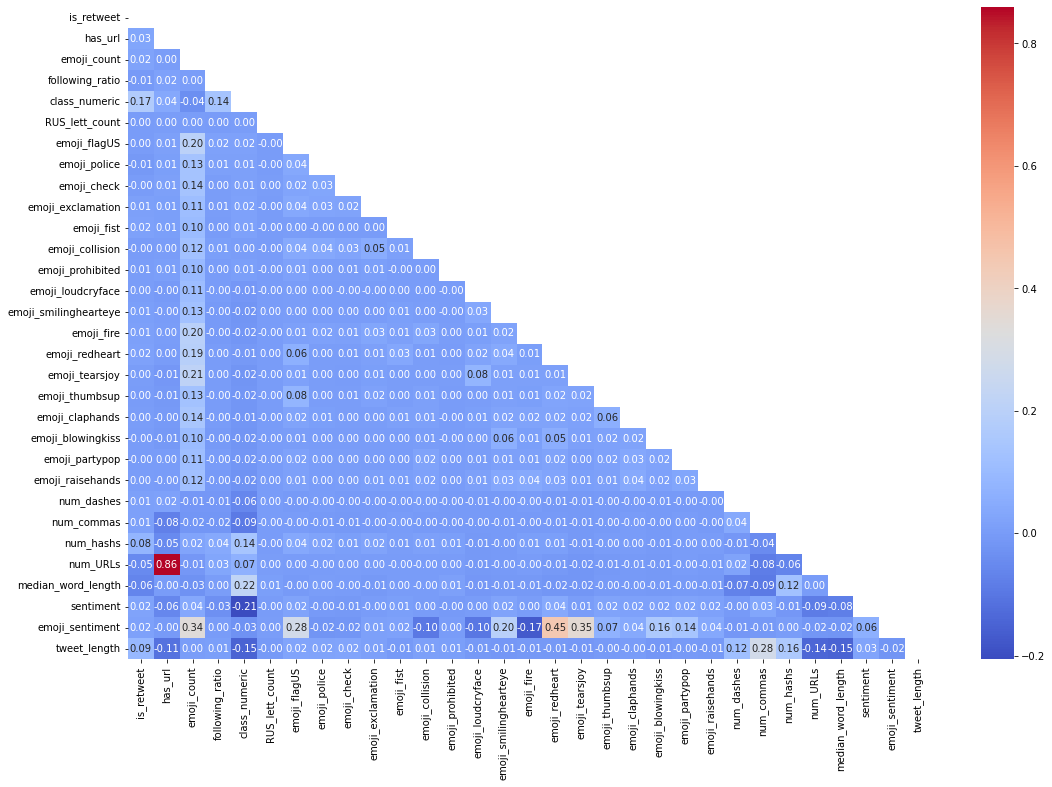

In [ ]:
#correlation heat map - tweet features

correlation_matrix_heatmap = df_tweet_features.corr()

# remove duplicate boxes in upper triangle
mask = np.zeros_like(correlation_matrix_heatmap)
mask[np.triu_indices_from(mask)] = True

# plot the correlation heat map to see connections amoung the dataset

fig, ax = plt.subplots(figsize=(18,12))   
ax = sns.heatmap(correlation_matrix_heatmap, 
    xticklabels = correlation_matrix_heatmap.columns, 
    yticklabels = correlation_matrix_heatmap.columns, 
    annot = True, mask = mask, cmap= 'coolwarm', fmt='.2f')

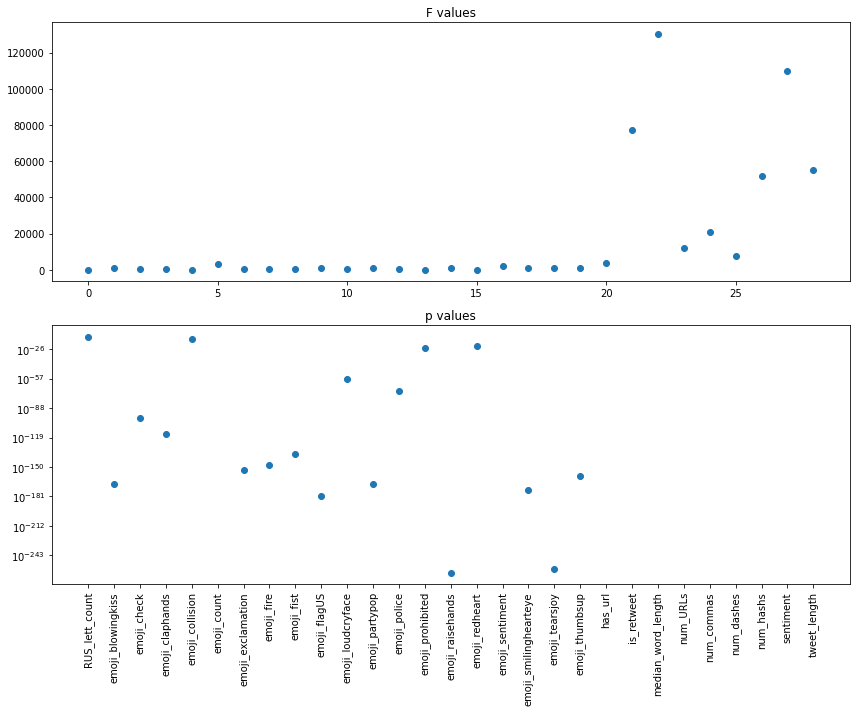

In [17]:
# tweet text features
from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(x_train, y_train)

fig, ax = plt.subplots(2, 1, figsize=(12,10))
ax[0].set_title("F values")
ax[0].plot(f_values, 'o')
ax[1].set_title("p values")
ax[1].plot(p_values, 'o')
ax[1].set_yscale("log")

ax[1].set_xticks(range(x_train.shape[1]))
ax[1].set_xticklabels(x_train.columns, rotation=90);
fig.tight_layout()

## Dummy Classifier

In [ ]:
dummy = DummyClassifier(strategy='stratified', random_state=42)

In [ ]:
dummy.fit(x_train, y_train)
dummy_pred = dummy.predict(x_test)
print("Accuracy Score:", accuracy_score(y_test, dummy_pred))

Accuracy Score: 0.5035


# 5 - Logistic Regression Classifier using StandardScaler Pipeline

In [28]:
lr = LogisticRegression(
    random_state=42,
    tol=0.0001,
    C=0.5,
    max_iter=1000
)
lr.fit(x_train, y_train)

LogisticRegression(C=0.5, max_iter=1000, random_state=42)

In [29]:
#view how many iterations were needed
lr.n_iter_

array([18], dtype=int32)

In [30]:
print("TRAIN Scores")
print(f'Accuracy score: {round(accuracy_score(y_train, lr.predict(x_train)), 3)}')
print(f'Precision score: {round(precision_score(y_pred=lr.predict(x_train), y_true=y_train),3)}')
print(f'Recall score: {round(recall_score(y_pred=lr.predict(x_train), y_true=y_train),3)}')
print(f'ROC/AUC score: {round(roc_auc_score(y_train, lr.predict_proba(x_train)[:,1]),3)}')

TRAIN Scores
Accuracy score: 0.684
Precision score: 0.685
Recall score: 0.684
ROC/AUC score: 0.745


In [31]:
#precisions, recalls, thresholds = precision_recall_curve(y_train, y_train)
y_train_scores = lr.decision_function(x_train)

In [32]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_scores)

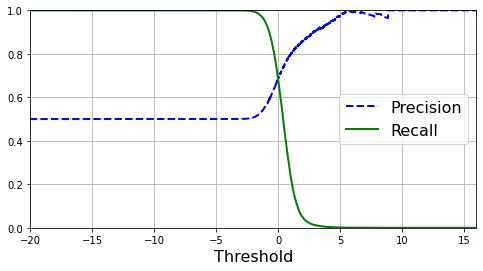

In [33]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-20, 16, 0, 1])             

plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

LR Model Test Predictions

In [34]:
#Predict on Test
lr_predict = lr.predict(x_test)


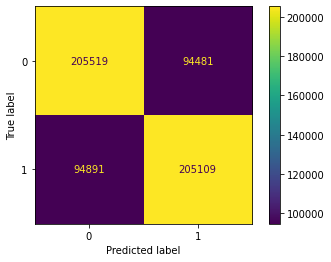

In [35]:
cm = confusion_matrix(y_test, lr.predict(x_test), labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels = lr.classes_)
disp.plot()
plt.show()

In [36]:
#get TEST Scores
#score = lr.score(x_test,y_test)
score = accuracy_score(y_test, lr.predict(x_test))
#Precision score for test
p_score = precision_score(lr_predict, y_test)
#recall for test
r_score = recall_score(lr_predict, y_test)
#ROC/AUC 
roc_auc = roc_auc_score(y_test, lr.predict_proba(x_test)[:,1])

print('TEST')
print('Accuracy:',round(score,3))
print('Precision:',round(p_score,3))
print('Recall:',round(r_score,3))
print('ROC/AUC:', round(roc_auc, 3))

TEST
Accuracy: 0.684
Precision: 0.684
Recall: 0.685
ROC/AUC: 0.745


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,lr_predict))

              precision    recall  f1-score   support

           0       0.68      0.69      0.68    300000
           1       0.68      0.68      0.68    300000

    accuracy                           0.68    600000
   macro avg       0.68      0.68      0.68    600000
weighted avg       0.68      0.68      0.68    600000



#### Identifying Features of Importance

In [38]:
#Reduced Features
coefs_features = list(zip(lr.coef_[0],x_train.columns))
for i in sorted(coefs_features):
  print(i)

(-0.42544700563761706, 'sentiment')
(-0.3514402842470149, 'tweet_length')
(-0.2829156619184946, 'has_url')
(-0.11197457953649782, 'emoji_count')
(-0.06767343935833453, 'num_dashes')
(-0.060096422870425804, 'num_commas')
(-0.05501524437362524, 'emoji_sentiment')
(-0.047360390508030904, 'emoji_raisehands')
(-0.045333990328426395, 'emoji_fire')
(-0.03336196853830005, 'emoji_blowingkiss')
(-0.03301757577728339, 'emoji_partypop')
(-0.029843863608596262, 'emoji_thumbsup')
(-0.021001013950472155, 'emoji_claphands')
(-0.019776152870295712, 'emoji_smilinghearteye')
(-0.01852913092632309, 'emoji_loudcryface')
(-0.007453131867090129, 'emoji_tearsjoy')
(0.018415593915823765, 'emoji_collision')
(0.024081265710367235, 'emoji_prohibited')
(0.039523721104456025, 'emoji_redheart')
(0.040602023326687324, 'emoji_police')
(0.04204002689458502, 'RUS_lett_count')
(0.05113571013947848, 'emoji_check')
(0.051761042695100117, 'emoji_fist')
(0.05845181584401797, 'emoji_exclamation')
(0.09214456389337636, 'emoji_

Most important (positive) features identified are:
1.   is_retweet
2.   median_word_length
3.   num_URLs
4.   num_hashs
5.   emoji_flag_US

Most important (negative) features identified are:
1.   sentiment
2.   tweet_length
3.   has_URL
4.   emoji_count
5.   num_dashes


# 6 - Decision Tree Classifier w/ StandardScaler

In [39]:
dt = DecisionTreeClassifier(
    random_state=42,
    min_samples_split=100,
    max_depth=6
)
dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=100, random_state=42)

In [40]:
print("TRAIN Scores")
print(f'Accuracy score: {round(accuracy_score(y_train, dt.predict(x_train)), 3)}')
print(f'Precision score: {round(precision_score(y_pred=dt.predict(x_train), y_true=y_train),3)}')
print(f'Recall score: {round(recall_score(y_pred=dt.predict(x_train), y_true=y_train),3)}')
print(f'ROC/AUC score: {round(roc_auc_score(y_train, dt.predict_proba(x_train)[:,1]),3)}')

TRAIN Scores
Accuracy score: 0.719
Precision score: 0.705
Recall score: 0.751
ROC/AUC score: 0.792


## Test Scores

In [41]:
#get TEST Scores
score = accuracy_score(y_test, dt.predict(x_test))
#Precision score for test
p_score = precision_score(dt.predict(x_test), y_test)
#recall for test
r_score = recall_score(dt.predict(x_test), y_test)
#ROC/AUC 
roc_auc = roc_auc_score(y_test, dt.predict_proba(x_test)[:,1])

print('TEST')
print('Accuracy:',round(score,3))
print('Precision:',round(p_score,3))
print('Recall:',round(r_score,3))
print('ROC/AUC:', round(roc_auc, 3))

TEST
Accuracy: 0.718
Precision: 0.75
Recall: 0.705
ROC/AUC: 0.791


# 7 - XGBoost Classifier using Standard Scaler

In [42]:
# Init classifier
xgb_cl = XGBClassifier()

# Fit
xgb_cl.fit(x_train, y_train)

# Predict
preds = xgb_cl.predict(x_test)

# Score
#accuracy_score(y_test, preds)

## Test Scores

In [43]:
#get TEST Scores
score = accuracy_score(y_test, preds)
#Precision score for test
p_score = precision_score(preds, y_test)
#recall for test
r_score = recall_score(preds, y_test)
#ROC/AUC 
roc_auc = roc_auc_score(y_test, preds)

print('TEST')
print('Accuracy:',score)
print('Precision:',p_score)
print('Recall:',r_score)
print('ROC/AUC:', roc_auc)

TEST
Accuracy: 0.7474966666666667
Precision: 0.7463333333333333
Recall: 0.7480738518285879
ROC/AUC: 0.7474966666666666


# Summary

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-bobw{font-weight:bold;text-align:center;vertical-align:bottom}
.tg .tg-j6zm{font-weight:bold;text-align:left;vertical-align:bottom}
.tg .tg-8d8j{text-align:center;vertical-align:bottom}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-bobw">&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;Models/Metrics</th>
    <th class="tg-bobw">Logistic Regression</th>
    <th class="tg-bobw">   <br>Decision Tree</th>
    <th class="tg-bobw">XGBoost</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-j6zm">&nbsp;&nbsp;&nbsp;<br>Accuracy</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;0.684</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>0.718</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>0.747</td>
  </tr>
  <tr>
    <td class="tg-j6zm">   <br>Precision</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;0.684</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>0.75</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>0.746</td>
  </tr>
  <tr>
    <td class="tg-j6zm">&nbsp;&nbsp;&nbsp;<br>Recall</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;0.685</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>0.705</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>0.748</td>
  </tr>
  <tr>
    <td class="tg-j6zm">&nbsp;&nbsp;&nbsp;<br>ROC/AUC</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>&nbsp;&nbsp;&nbsp;0.745</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>0.791</td>
    <td class="tg-8d8j">&nbsp;&nbsp;&nbsp;<br>0.747</td>
  </tr>
</tbody>
</table>